In [ ]:
# import necessary libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.interpolate import CubicSpline

# OIS curve bootstrapper class
class OISCurveBootstrapper:
    def __init__(self, deposits, swaps, day_count="ACT/360"):
        self.deposits = deposits # list of (tenor_days, rate)
        self.swaps = swaps # list of (maturity_years, par_rate, frequency)
        self.day_count = day_count
        self.discount_factors = {}

    # bootstrap method
    def bootstrap(self):
        # bootstrap deposits 
        for tenor_days, rate in self.deposits:
            T = tenor_days / 360.0 # simplified day count
            self.discount_factors[T] = 1 / (1 + rate * T)

        # bootstrap OIS swaps sequentially
        for maturity, par_rate, freq in self.swaps:
            # build payment schedule
            payment_times = np.linspace(freq, maturity, int(maturity / freq))
            known_pv = 0.0
            last_T = payment_times[-1]

            # sum known DFs
            for t in payment_times[:-1]:
                delta = freq
                known_pv += par_rate * delta * self.discount_factors.get(t, 1.0)

            # solve for final DF
            last_delta = freq
            self.discount_factors[last_T] = (1 - known_pv) / (1 + par_rate * last_delta)

        return self.discount_factors
    
    def interpolate_curve(self, fine_grid):
        # cubic int on log-discounts for stability
        known_T = sorted(self.discount_factors.keys())
        known_df = [self.discount_factors[T] for T in known_T]
        log_df = np.log(known_df)
        cs = CubicSpline(known_T, log_df)
        return {T: np.exp(cs(T)) for T in fine_grid}
    
    def forward_rate(self, T1, T2):
        P1 = self.discount_factors[T1] if T1 in self.discount_factors else None
        P2 = self.discount_factors[T2] if T2 in self.discount_factors else None
        if P1 is None or P2 is None:
            interp = self.interpolate_curve([T1, T2])
            P1 = interp[T1]
            P2 = interp[T2]
        delta = T2 - T1
        return (P1 / P2 - 1) / delta
    
    def plot_discount_factors(self):
        T = sorted(self.discount_factors.keys())
        P = [self.discount_factors[t] for t in T]
        plt.figure(figsize=(8,4))
        plt.plot(T, P)
        plt.title("Discount Factor Curve")
        plt.xlabel("Time (Years)")
        plt.ylabel("Discount Factor")
        plt.grid(True)
        plt.show()

    def plot_zero_curve(self):
        T = sorted(self.discount_factors.keys())
        zero_rates = [(1/self.discount_factors[t] - 1)/t for t in T]
        plt.figure(figsize=(8,4))
        plt.plot(T, zero_rates)
        plt.title("Zero Rate Curve")
        plt.xlabel("Time (Years)")
        plt.ylabel("Zero Rate")
        plt.grid(True)
        plt.show()

    def plot_forward_curve(self):
        T = sorted(self.discount_factors.keys())
        mids = [(T[i] + T[i+1])/2 for i in range(len(T)-1)]
        fwds = [self.forward_rate(T[i], T[i+1]) for i in range(len(T)-1)]
        plt.figure(figsize=(8,4))
        plt.plot(mids, fwds)
        plt.title("Forward Rate Curve")
        plt.xlabel("Time (Years)")
        plt.ylabel("Forward Rate")
        plt.grid(True)
        plt.show()

    def plot_curves(self):
        T = sorted(self.discount_factors.keys())
        P = [self.discount_factors[t] for t in T]
        zero_rates = [((1/self.discount_factors[t] - 1)/t) * 100 for t in T]
        fwds_T = [(T[i] + T[i+1]) / 2 for i in range(len(T)-1)]
        fwds = [self.forward_rate(T[i], T[i+1]) * 100 for i in range(len(T)-1)]

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=T, y=P, mode="lines", name="Discount Factors"))
        fig.add_trace(go.Scatter(x=T, y=zero_rates, mode="lines", name="Zero Rates (%)"))
        fig.add_trace(go.Scatter(x=fwds_T, y=fwds, mode="lines", name="Forward Rates (%)"))

        fig.update_layout(
            title="OIS Curve Components",
            xaxis_title="Time (Years)",
            yaxis_title="Value",
            hovermode="x unified",
            template="plotly_white"
        )

        fig.show()


In [12]:
deposits = [
    (1,   0.0547),
    (7,   0.0548),
    (14,  0.0549),
    (30,  0.0551),
    (60,  0.0553),
    (90,  0.0556),
    (180, 0.0560),
    (270, 0.0563),
    (360, 0.0565)
]

swaps = [
    (1,   0.0560, 0.25),
    (2,   0.0569, 0.25),
    (3,   0.0577, 0.25),
    (4,   0.0582, 0.25),
    (5,   0.0584, 0.25),
    (6,   0.0586, 0.25),
    (7,   0.0588, 0.25),
    (10,  0.0590, 0.25),
    (12,  0.0588, 0.25),
    (15,  0.0584, 0.25),
    (20,  0.0579, 0.25),
    (25,  0.0572, 0.25),
    (30,  0.0565, 0.25)
]


In [19]:
curve = OISCurveBootstrapper(deposits, swaps)
curve.bootstrap()
curve.plot_curves()


In [28]:
import pandas as pd

url = "https://raw.githubusercontent.com/epogrebnyak/data-ust/master/ust.csv"
df = pd.read_csv(url, parse_dates=["date"]).set_index("date")
latest = df.iloc[-1]

tenor_columns = {
    "BC_1MONTH": 1/12,
    "BC_3MONTH": 3/12,
    "BC_6MONTH": 6/12,
    "BC_1YEAR": 1,
    "BC_2YEAR": 2,
    "BC_3YEAR": 3,
    "BC_5YEAR": 5,
    "BC_7YEAR": 7,
    "BC_10YEAR": 10,
    "BC_20YEAR": 20,
    "BC_30YEAR": 30
}

discount_factors = {}
for col, T in tenor_columns.items():
    rate = latest[col] / 100.0
    P = 1 / (1 + rate * T)
    discount_factors[T] = P

curve = OISCurveBootstrapper(deposits=[], swaps=[])
curve.discount_factors = discount_factors
curve.plot_curves()


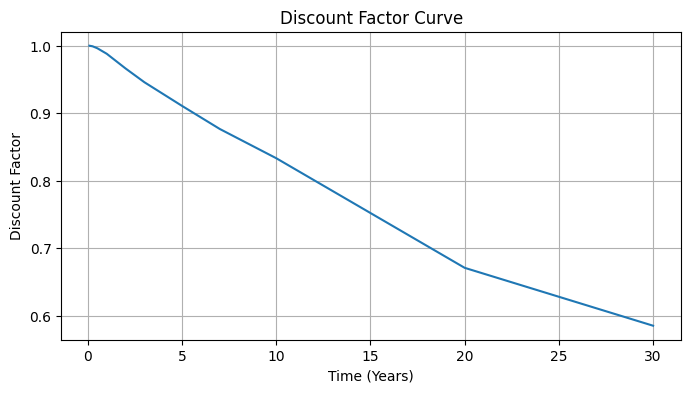

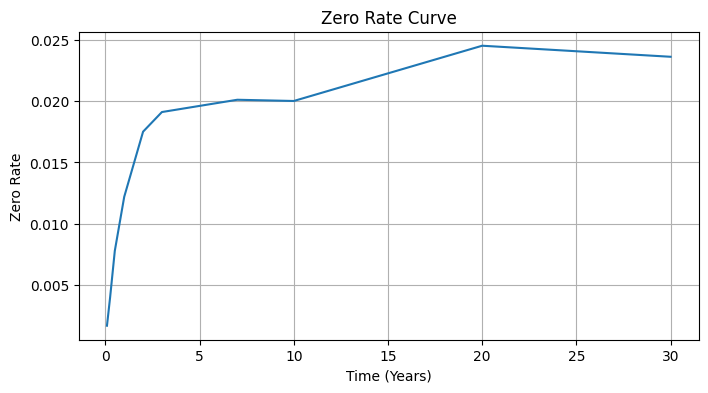

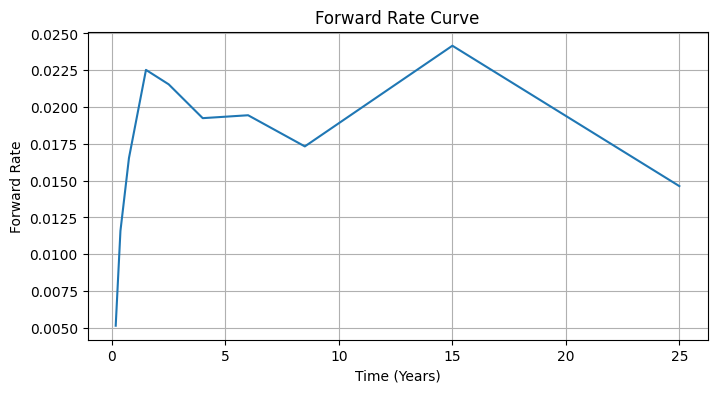

In [27]:
curve.plot_discount_factors()
curve.plot_zero_curve()
curve.plot_forward_curve()